<a href="https://colab.research.google.com/github/Viny2030/pennylane/blob/master/2_differentiable_quantum_computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib

# Differentiable quantum computing with PennyLane

In this tutorial we will:

* learn step-by-step how quantum computations are implemented in PennyLane,
* understand parameter-dependent quantum computations ("variational circuits"),
* build our first quantum machine learning model, and
* compute its gradient.

We need the following imports:

Computación cuántica diferenciable con PennyLane
En este tutorial: **texto en negrita**

aprenderemos paso a paso cómo se implementan los cálculos cuánticos en PennyLane,
entenderemos los cálculos cuánticos dependientes de parámetros ("circuitos variacionales"),
construiremos nuestro primer modelo de aprendizaje automático cuántico y
calcularemos su gradiente.
Necesitamos las siguientes importaciones:

In [2]:
import pennylane as qml
from pennylane import numpy as np

## 1. Quantum nodes

In PennyLane, a *quantum node* is a computational unit that involves the construction, evaluation, pre- and postprocessing of quantum computations.

A quantum node consists of a *quantum function* that defines a circuit, as well as a *device* on which it is run.

There is a growing [device ecosystem](https://pennylane.ai/plugins.html) which allows you to change only one line of code to dispatch your quantum computation to local simulators, remote simulators and remote hardware from different vendors.

Here we will use the built-in `default.qubit` device.

En PennyLane, un nodo cuántico es una unidad computacional que implica la construcción, evaluación, preprocesamiento y posprocesamiento de cálculos cuánticos.

Un nodo cuántico consiste en una función cuántica que define un circuito, así como un dispositivo en el que se ejecuta.

Existe un ecosistema de dispositivos en crecimiento que permite modificar una sola línea de código para enviar el cálculo cuántico a simuladores locales, simuladores remotos y hardware remoto de diferentes proveedores.

Aquí utilizaremos el dispositivo integrado `default.qubit`.

In [3]:
dev = qml.device('default.qubit', wires=2)

To combine the device with a quantum function to a quantum node we can use the `qml.qnode` decorator. The function can then be evaluated as if it was any other python function. Internally, it will construct a circuit and run it on the device.

**Para combinar el dispositivo con una función cuántica en un nodo cuántico, podemos usar el decorador qml.qnode. La función puede evaluarse como cualquier otra función de Python. Internamente, construirá un circuito y lo ejecutará en el dispositivo.**

In [4]:
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    return qml.probs(wires=[0, 1])

circuit()

array([0.5, 0. , 0.5, 0. ])

## 2. Building quantum circuits

### The initial state

<br />
<img src="https://github.com/XanaduAI/pennylane-demo-cern/blob/main/figures/1.png?raw=1" width="500" height="100">
<br />

The initial state has 100% probability to be measured in the "0..0" configuration. Let's see how we can verify this with PennyLane.

**El estado inicial tiene un 100 % de probabilidad de medirse en la configuración "0..0". Veamos cómo podemos verificar esto con PennyLane.**

The internal state vector that we use to mathematically keep track of probabilities is complex-valued. Since `default.qubit` is a simulator we can have a look at the state, for example by checking the device's `state` attribute.

El vector de estado interno que usamos para el seguimiento matemático de las probabilidades tiene un valor complejo. Dado que default.qubit es un simulador, podemos observar el estado, por ejemplo, consultando el atributo de estado del dispositivo.

In [7]:
@qml.qnode(dev)
def circuit():
    return qml.probs(wires=[0, 1])

circuit()

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

### Unitary evolutions

<br />
<img src="https://github.com/XanaduAI/pennylane-demo-cern/blob/main/figures/2.png?raw=1" width="500">
<br />

Quantum circuits are represented by unitary matrices. We can evolve the initial state by an arbitrary unitrary matrix as follows:

Los circuitos cuánticos se representan mediante matrices unitarias. Podemos desarrollar el estado inicial mediante una matriz unitaria arbitraria de la siguiente manera:

In [8]:
s = 1/np.sqrt(2)
U = np.array([[0., -s, 0.,  s],
              [ s, 0., -s, 0.],
              [ s, 0.,  s, 0.],
              [0., -s, 0., -s]])

@qml.qnode(dev)
def circuit():
    qml.QubitUnitary(U, wires=[0, 1])
    return qml.probs(wires=[0, 1])

circuit()

tensor([0. , 0.5, 0.5, 0. ], requires_grad=True)

The internal quantum state changed.

In [11]:
qml.state()

state(wires=[])

### Measurements sample outcomes from the distribution

<br />
<img src="https://github.com/XanaduAI/pennylane-demo-cern/blob/main/figures/3.png?raw=1" width="500">
<br />

The most common measurement takes samples $-1, 1$ from the "Pauli-Z" observable. The samples indicate if the qubit was measured in state $| 0 \rangle$ or $| 1 \rangle$.

La medición más común toma muestras −1,1 del observable "Pauli-Z". Las muestras indican si el cúbit se midió en el estado |0⟩ o |1⟩.

In [13]:
@qml.qnode(dev)
def circuit():
    qml.QubitUnitary(U, wires=[0, 1])
    return qml.sample(qml.PauliZ(wires=0)), qml.sample(qml.PauliZ(wires=1))

circuit()

(tensor(0., requires_grad=True), tensor(0., requires_grad=True))

The quantum state should be still the same as above.

**El estado cuántico debería seguir siendo el mismo que el anterior.**

In [14]:
dev.state

AttributeError: DefaultQubit has no attribute 'state'. You may be looking for a property or method present in the legacy device interface. Please consult the DefaultQubit documentation for an updated list of public properties and methods.

### Computing expectation values

<br />
<img src="https://github.com/XanaduAI/pennylane-demo-cern/blob/main/figures/4.png?raw=1" width="500">
<br />

When we want outputs of computations to be deterministic, we often interpret the expected measurement outcome as the result. This value is estimated by taking lots of samples and averaging over them.

Cuando queremos que los resultados de los cálculos sean deterministas, solemos interpretar el resultado esperado de la medición como el resultado. Este valor se estima tomando muchas muestras y promediándolas.

In [16]:
@qml.qnode(dev)
def circuit():
    qml.QubitUnitary(U, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliZ(wires=1))

circuit()

(tensor(0., requires_grad=True), tensor(0., requires_grad=True))

Again, the quantum state should be the same as above.

In [ ]:
dev.state

tensor([0.        +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.        +0.j], requires_grad=True)

### Quantum circuits are decomposed into gates

<br />
<img src="https://github.com/XanaduAI/pennylane-demo-cern/blob/main/figures/5.png?raw=1" width="500">
<br />

Quantum circuits rarely consist of one large unitary (which quickly becomes intractably large as the number of qubits grow). Instead, they are composed of *quantum gates*.

In [17]:
@qml.qnode(dev)
def circuit():
    qml.PauliX(wires=0)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=0)
    qml.PauliZ(wires=1)
    return qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliZ(wires=1))

circuit()

(np.float64(0.0), np.float64(-0.9999999999999998))

### Some gates depend on "control" parameters

<br />
<img src="https://github.com/XanaduAI/pennylane-demo-cern/blob/main/figures/6.png?raw=1" width="500">
<br />

To train circuits, there is a special subset of gates which is of particular interest: the Pauli rotation gates. These "rotate" a special representation of the quantum state around a specific axis. The gates depend on a scalar parameter which is the angle of the rotation.

Para entrenar circuitos, existe un subconjunto especial de puertas de particular interés: las puertas de rotación de Pauli. Estas "rotan" una representación especial del estado cuántico alrededor de un eje específico. Las puertas dependen de un parámetro escalar: el ángulo de rotación.

In [18]:
@qml.qnode(dev)
def circuit(w1, w2):
    qml.RX(w1, wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(w2, wires=1)
    return qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliZ(wires=1))

circuit(1.2, 1.3)

(np.float64(0.3623577544766737), np.float64(0.09693027486554612))

The names `w1`, `w2` are already suggestive that these can be used like the trainable parameters of a classical machine learning model. But we could also call the control parameters `x1`, `x2` and encode data features into quantum states.

Los nombres w1 y w2 ya sugieren que pueden usarse como parámetros entrenables de un modelo clásico de aprendizaje automático. Sin embargo, también podríamos llamar a los parámetros de control x1 y x2 y codificar las características de los datos en estados cuánticos.

## 3. A full quantum machine learning model and its gradient

Finally, we can use pre-coded routines or [templates](https://pennylane.readthedocs.io/en/stable/introduction/templates.html) to conveniently build full quantum machine learning model that include a data encoding part, and a trainable part.

<br />
<img src="https://github.com/XanaduAI/pennylane-demo-cern/blob/main/figures/7.png?raw=1" width="500">
<br />

Here, we will use the `AngleEmbedding` template to load the data, and the `BasicEntanglingLayers` as the trainable part of the circuit.

Por último, podemos utilizar rutinas o plantillas precodificadas para construir cómodamente un modelo completo de aprendizaje automático cuántico que incluya una parte de codificación de datos y una parte entrenable.
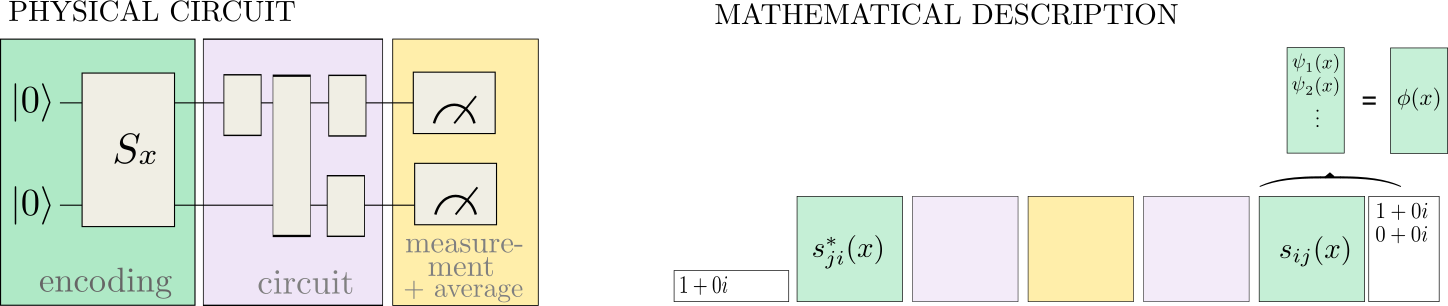

Aquí, utilizaremos la plantilla AngleEmbedding para cargar los datos y BasicEntanglingLayers como la parte entrenable del circuito.

In [19]:
@qml.qnode(dev)
def quantum_model(x, w):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=0))


x = np.array([0.1, 0.2], requires_grad=False)
w = np.array([[-2.1, 1.2], [-1.4, -3.9], [0.5, 0.2]])

quantum_model(x, w)

tensor(0.012023, requires_grad=True)

We can draw the circuit.

In [21]:
print(qml.draw(quantum_model)(x, w))

0: ─╭AngleEmbedding(M0)─╭BasicEntanglerLayers(M1)─┤  <Z>
1: ─╰AngleEmbedding(M0)─╰BasicEntanglerLayers(M1)─┤     

M0 = 
[0.1 0.2]
M1 = 
[[-2.1  1.2]
 [-1.4 -3.9]
 [ 0.5  0.2]]


The best thing is that by using PennyLane, we can easily compute its gradient!

¡Lo mejor es que al usar PennyLane podemos calcular fácilmente su gradiente!

In [22]:
gradient_fn = qml.grad(quantum_model)

gradient_fn(x, w)

array([[ 1.69541373e-01, -6.50521303e-17],
       [ 6.97079563e-02,  8.67361738e-18],
       [ 1.69541373e-01,  3.53449908e-17]])

This allows us to slot the quantum circuit into the machine learning example from the previous notebook.

Esto nos permite insertar el circuito cuántico en el ejemplo de aprendizaje automático del cuaderno anterior.

#  TASKS

1. Copy and paste the code from the previous notebook to here and replace the classical model by
   the `quantum_model` function. This will allow you to train the model!

**TAREAS**
Copia y pega aquí el código del cuaderno anterior y reemplaza el modelo clásico por la función quantum_model. ¡Esto te permitirá entrenar el modelo!

2. Add a bias term to the quantum model.

A potential solution of 1 & 2 together:

Añadir un término de sesgo al modelo cuántico.
Una posible solución de 1 y 2 juntos:

In [23]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1),
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)])
X1 = np.array([[np.random.normal(loc=1, scale=1),
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)])

X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))

def model_with_bias(x, w, b):
    return quantum_model(x, w) + b

def loss(a, b):
    return (a - b)**2

def average_loss(w, b, data):
    c = 0
    for x, y in data:
        prediction = model_with_bias(x, w, b)
        c += loss(prediction, y)
    return c/len(data)

gradient_fn_w = qml.grad(average_loss, argnum=0)
gradient_fn_b = qml.grad(average_loss, argnum=1)

w_init = np.random.random(size=(3, 2))
w = np.array(w_init)
b = np.array(0.0) # start with zero bias

for i in range(15):
    w_new = w - 0.05*gradient_fn_w(w, b, data)
    b_new = b - 0.05*gradient_fn_b(w, b, data)
    print(average_loss(w_new, b_new, data))
    w = w_new
    b = b_new

1.8849316735960846
1.7994290353261422
1.713760627333761
1.6297475998593294
1.5490346618102533
1.4729633996299936
1.4024972209368827
1.3382019331683566
1.2802738404498952
1.2286000998063868
1.1828345298834284
1.1424746678510642
1.1069304425915563
1.0755795166496755
1.047808062816081


3. Replace the hand-coded optimisation step by a native [PennyLane optimiser](https://pennylane.readthedocs.io/en/stable/introduction/optimizers.html).

Reemplace el paso de optimización codificado manualmente por un optimizador nativo de PennyLane.

In [24]:
opt = qml.GradientDescentOptimizer(0.05)
for i in range(15):

    ([w, b], cst) = opt.step_and_cost(lambda w_, b_: average_loss(w_, b_, data), w, b)
    print(cst)

1.047808062816081
1.02303813532561
1.0007439951104116
0.9804600805408366
0.961783125281123
0.9443704884333883
0.9279362614863084
0.9122462536382987
0.8971125766465261
0.8823882625673243
0.8679621447469321
0.8537540991067171
0.8397106627976454
0.8258010058781525
0.8120132165232465


4. Rewrite the entire example in PyTorch.

   Tipp: You must set the qnode to the correct interface via `@qml.qnode(dev, interface='tf')`.

Reescribe el ejemplo completo en PyTorch.

Consejo: Debes configurar el nodo q con la interfaz correcta mediante @qml.qnode(dev, interface='tf').

In [25]:
import torch

data = [[torch.tensor(x), torch.tensor(y)] for x, y in data]


@qml.qnode(dev, interface='torch')
def quantum_model(x, w):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=0))

def average_loss(w, data):
    c = 0
    for x, y in data:
        prediction = quantum_model(x, w)
        c += loss(prediction, y)
    return c/len(data)

w_init = np.random.random(size=(3, 2))

w = torch.tensor(w_init, requires_grad=True)

opt = torch.optim.Adam([w], lr = 0.1)

# One way of optimising is to use closures
def closure():
    opt.zero_grad()
    loss = average_loss(w, data)
    loss.backward()
    return loss

for i in range(15):
    opt.step(closure)

    print(average_loss(w, data))


tensor(2.3819, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(2.2084, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(2.0031, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(1.7805, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(1.5550, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(1.3406, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(1.1495, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.9918, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.8738, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.7965, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.7541, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.7344, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.7242, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.7144, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.7017, dtype=torch.float64, grad_fn=<DivBackward0>)
